On considère le problème du labyrinthe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import copy
np.set_printoptions(precision=3)
%matplotlib inline

On modélise le problème par:
- un ensemble d'états $\mathcal{S}=\left\{ 1,\dots,n \right\}\times
  \left\{ 1,\dots,m \right\}$ qui correspond aux cellules,
- un ensemble d'actions $\mathcal{A}=\left\{ 0,1,2,3 \right\}$ qui correspondent respectivement à "bas", "droite", "haut", "gauche", et dont on utilisera parfois la représentation sous forme de vecteur,
- un ensemble de gains $\mathcal{R}=\left\{ 0,1 \right\}$
- un ensemble d'états appelés "murs intérieurs" $\mathcal{W}\subset \mathcal{A}$.

Les transitions sont toutes déterministes, et sont telles qu'on obtient un gain de 1 lorsqu'on se déplace vers la cellule d'arrivée depuis une cellule voisine, et un gain de 0 sinon. Si l'action choisie correspond à un déplacement non-autorisé (soit qu'il mène à l'extérieur du labyrinthe, soit qu'il mène vers un mur intérieur, soit que l'état actual est un mur intérieur), l'état reste inchangé.

On travaillera avec une valeur $\gamma=.9$ fixée.

La fonction suivante servira à représenter graphiquement le labyrinthe, les politiques, ainsi que les chemins empruntés par les politiques.

In [2]:
def plot(policy=None, path=False, a = 4):
    grid_size = maze.shape
    fig, ax = plt.subplots(figsize=((grid_size[1]+1)//a, (grid_size[0]+1)//a))
    im = ax.imshow(maze, cmap='Greys', interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=1)
    ax.set_xticks(np.arange(0, grid_size[1]+1, 1), minor=True)
    ax.set_yticks(np.arange(0, grid_size[0]+1, 1), minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    if policy is not None:
        # Plot arrows
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                action = policy[i, j]
                ax.text(j + 0.5, grid_size[0] - i - 0.5, action_arrows[action],
                        ha='center', va='center', fontsize=12, fontweight='bold')
        if path is True:
            cmap = pl.cm.Reds
            my_cmap = cmap(np.arange(cmap.N))
            my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
            my_cmap = ListedColormap(my_cmap)
            im = ax.imshow(path_array(policy), cmap=my_cmap, interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=.5)
    plt.show()

Le code suivant construit un labyrinthe aléatoire de taille 30 x 30, avec des murs intérieurs qui ne sont pas tirés de façon indépendante. La case de départ est (0,0) (celle en haut à gauche), et la case d'arrivée est (29,29) (celle en bas à droite). Il est fait en sorte que ces deux cases ne soient pas murées. Les paramètres peuvent bien sûr être modifiés.

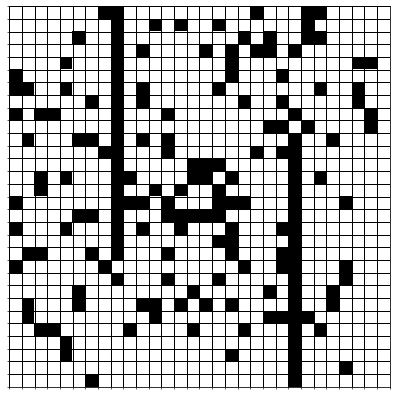

In [3]:
width = 30
height = 30
maze_size = (height, width) # nb lines & nb rows
start_cell = (0,0)
target_cell = (height-1, width-1)

maze = np.random.binomial(1, p=.15, size=maze_size)
maze[:round(2*width/3),round(height/4)] = 1
maze[round(width/3):,round(3*height/4)] = 1
chl = round(2*height/5)
chu = round(3*height/5)
cwl = round(2*width/5)
cwu = round(3*width/5)
maze[chl:chu,cwl:cwu] = np.random.binomial(1, p=.5, size=(chu-chl, cwu-cwl))
maze[start_cell] = 0
maze[target_cell] = 0
plot()

*Attention* : vérifier visuellement que le labyrinthe ainsi obtenu possède un chemin allant de la case de départ à la case d'arriver. Dans le cas contraire, relancer le code ci-dessus afin de générer un autre labyrinthe.

In [4]:
actions = [0,1,2,3]
action_coordinates = {0: np.array([1,0]),# down
                      1: np.array([0,1]), # right
                      2: np.array([-1,0]), # up
                      3: np.array([0,-1])} # left
action_arrows = ['↓', '→', '↑', '←']
gamma = .9

On ne va travailler qu'avec des politiques stationnaires déterministes $\pi:\mathcal{S}\to \mathcal{A}$. On va les représenter par des arrays de taille $n\times m$ à valeurs dans $\left\{ 0,1,2,3 \right\}$.

*Question 1*: Compléter la fonction suivante qui prend en entrée un état (un couple de la forme (i,j)) et une action (un entier parmi 0,1,2,3), et qui renvoie r, s_, qui sont respectivement le gain et le nouvel état. On pourra utiliser la fonction `tuple` qui convertit en n-uplet un objet d'un autre type.

In [5]:
def transition(s, a):
    i, j = s
    if a == 0:  # down
        if i < maze.shape[0] - 1 and maze[i + 1, j] != 1:
            s_ = (i + 1, j)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    elif a == 1:  # right
        if j < maze.shape[1] - 1 and maze[i, j + 1] != 1:
            s_ = (i, j + 1)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    elif a == 2:  # up
        if i > 0 and maze[i - 1, j] != 1:
            s_ = (i - 1, j)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    elif a == 3:  # left
        if j > 0 and maze[i, j - 1] != 1:
            s_ = (i, j - 1)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    return r, s_

*Question 2*: Compléter les fonctions suivantes qui calculent l'image d'une fonction état-valeur par les opérateurs de Bellman $B_{\pi}^{(V)}$ et $B_*^{(V)}$. Une fonction état-valeur sera représentée par un array de taille $n\times m$, et une politique (qu'on suppose donc stationnaire et déterministe), par un array de taille $n\times m$ à valeurs dans $\left\{ 0,1,2,3 \right\}$.

In [6]:
def B_pi(v, pi):
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            a = pi[s]
            r, s_ = transition(s, a)
            v_[s] = (r + gamma * v[s_])
    return v_

def B_star(v):
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            max_value = -np.inf
            for a in actions:
                r, s_ = transition(s, a)
                value = r + gamma * v[s_]
                if value > max_value:
                    max_value = value
            v_[s] = max_value
    return v_

*Question 3*: Compléter la fonction suivante qui renvoie une politique gloutonne par rapport à une fonction état-valeur donnée en entrée. On pourra utiliser la fonction np.argmax.

In [7]:
def greedy_policy(v):
    pi = np.zeros_like(maze)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            max_value = -np.inf
            for a in actions:
                r, s_ = transition(s, a)
                value = r + gamma * v[s_]
                if value > max_value:
                    max_value = value
                    pi[s] = a
    return pi

def stationnary_policy(v):
    return np.random.randint(0, 4, size=v.shape)

### Question 6 de l'évaluation

In [9]:
v_0 = np.random.random(maze.shape)
policy = stationnary_policy(v_0)

In [34]:
v_star = copy.deepcopy(v_0)

for _ in range(10000):
    v_star = B_pi(v_star, policy)


In [35]:
policy = stationnary_policy(v_0)
v = copy.deepcopy(v_0)

diff_Bpi = [np.max(np.abs(B_pi(v, policy)-v))]
diff_vpi = [np.max(np.abs(v-v_star))]

dic_Bpi = {}
dic_vpi = {}

for _ in range(1000):
    v = B_pi(v, policy)
    diff_Bpi.append(np.max(np.abs(B_pi(v, policy)-v)))
    diff_vpi.append(np.max(np.abs(v-v_star)))

dic_Bpi['pi'] = copy.deepcopy(diff_Bpi)
dic_vpi['pi'] = copy.deepcopy(diff_vpi)

eta_tab = 10**np.linspace(0.01, 3, 10)[:-1]

for eta in eta_tab:
    v = copy.deepcopy(v_0)

    temp = [np.linalg.norm(B_pi(v, policy)-v)]
    diff_Bpi = [np.max(np.abs(B_pi(v, policy)-v))]
    diff_vpi = [np.max(np.abs(B_pi(v, policy)-v))]

    for _ in range(1000):
        v = v + eta * (B_pi(v, policy)-v)/np.sqrt(np.sum(temp))
        diff_Bpi.append(np.max(np.abs(B_pi(v, policy)-v)))
        diff_vpi.append(np.max(np.abs(v-v_star)))
        temp.append(np.linalg.norm(B_pi(v, policy)-v))

    dic_Bpi[eta] = copy.deepcopy(diff_Bpi)
    dic_vpi[eta] = copy.deepcopy(diff_vpi)

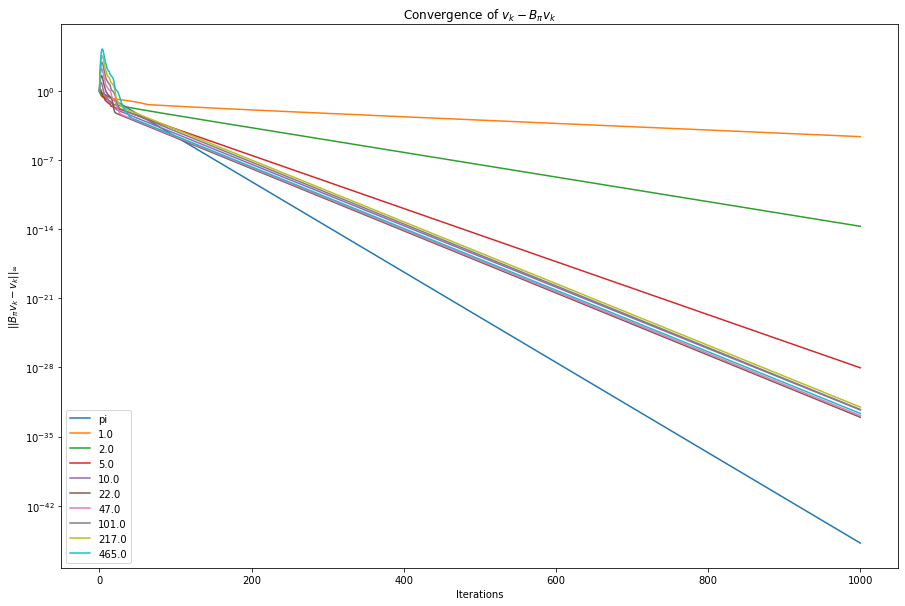

In [36]:
fig = plt.figure(figsize=(15, 10))

for key, value in dic_Bpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $v_k - B_{\pi}v_k$')
plt.xlabel('Iterations')
plt.ylabel('$||B_{\pi}v_{k}-v_{k}||_{\infty}$')
plt.legend()
plt.show()

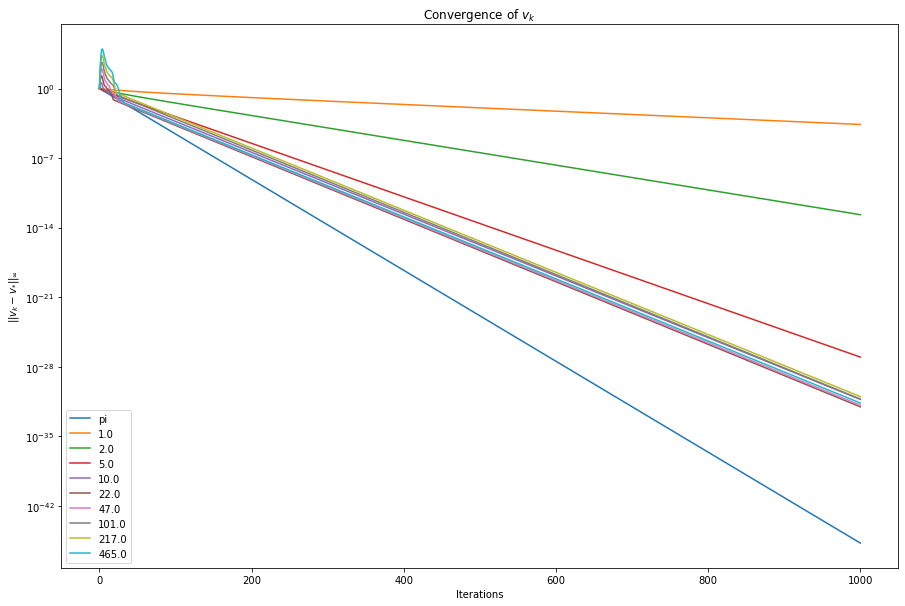

In [37]:
fig = plt.figure(figsize=(15, 10))


for key, value in dic_vpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $v_{k}$')
plt.xlabel('Iterations')
plt.ylabel('$||v_{k}-v_{*}||_{\infty}$')
plt.legend()
plt.show()


### Question 7 de l'évaluation

In [38]:
v_star = copy.deepcopy(v_0)

for _ in range(10000):
    v_star = B_star(v_star)

In [39]:
v = copy.deepcopy(v_0)

diff_Bpi = [np.max(np.abs(B_star(v)-v))]
diff_vpi = [np.max(np.abs(v-v_star))]

dic_Bpi = {}
dic_vpi = {}

for _ in range(1000):
    v = B_star(v)
    diff_Bpi.append(np.max(np.abs(B_star(v)-v)))
    diff_vpi.append(np.max(np.abs(v-v_star)))

dic_Bpi['pi'] = copy.deepcopy(diff_Bpi)
dic_vpi['pi'] = copy.deepcopy(diff_vpi)

eta_tab = 10**np.linspace(0.01, 3, 10)[:-1]

for eta in eta_tab:
    v = copy.deepcopy(v_0)

    temp = [np.linalg.norm(B_star(v)-v)]
    diff_Bpi = [np.max(np.abs(B_star(v)-v))]
    diff_vpi = [np.max(np.abs(v-v_star))]

    for _ in range(1000):
        v = v + eta * (B_star(v)-v)/np.sqrt(np.sum(temp))
        diff_Bpi.append(np.max(np.abs(B_star(v)-v)))
        diff_vpi.append(np.max(np.abs(v-v_star)))
        temp.append(np.linalg.norm(B_pi(v, policy)-v))

    dic_Bpi[eta] = copy.deepcopy(diff_Bpi)
    dic_vpi[eta] = copy.deepcopy(diff_vpi)

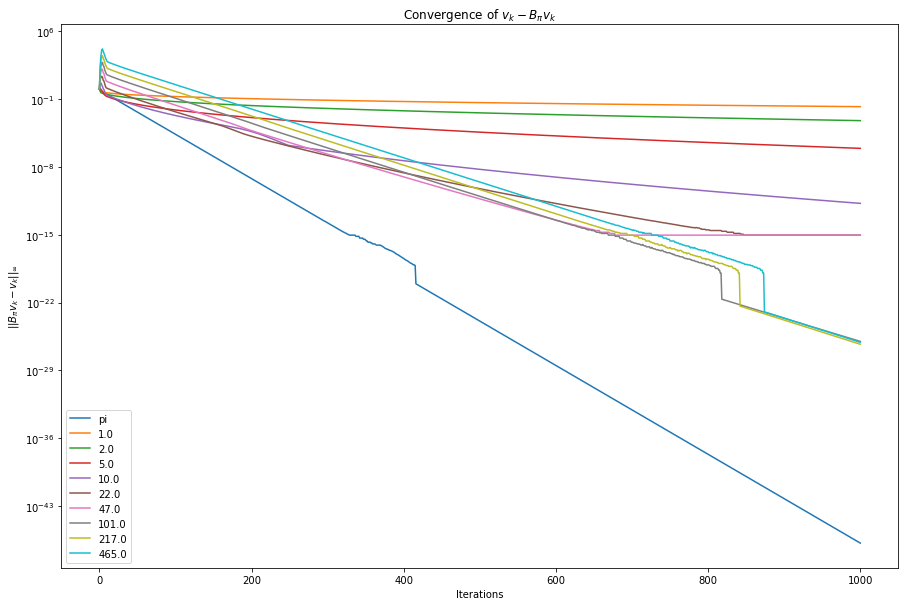

In [40]:
fig = plt.figure(figsize=(15, 10))

for key, value in dic_Bpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $v_k - B_{\pi}v_k$')
plt.xlabel('Iterations')
plt.ylabel('$||B_{\pi}v_{k}-v_{k}||_{\infty}$')
plt.legend()
plt.show()

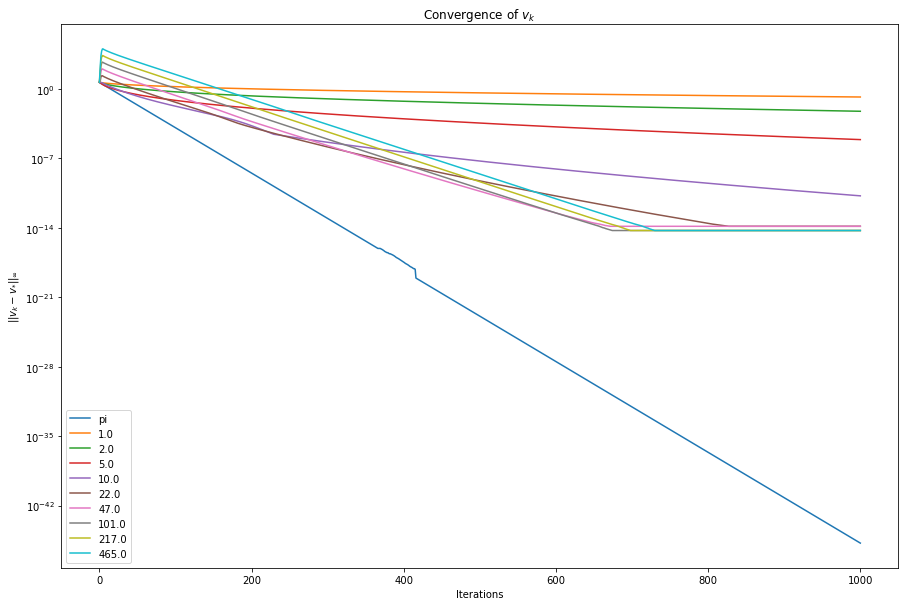

In [41]:
fig = plt.figure(figsize=(15, 10))


for key, value in dic_vpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $v_{k}$')
plt.xlabel('Iterations')
plt.ylabel('$||v_{k}-v_{*}||_{\infty}$')
plt.legend()
plt.show()


# Partie 3

In [21]:
def B_pi(v, pi):
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            a = pi[s]
            r, s_ = transition(s, a)
            v_[s] = (r + gamma * v[s_])
    return v_

### Itération action valeur

In [31]:
def B_pi_action(q, pi): 
    q_ = np.zeros([q.shape[0], q.shape[1], q.shape[2]])
    for i in range(q.shape[0]) :
        for j in range(q.shape[1]) :
            for a in range(4):
                s = (i, j)
                r, s_ = transition(s, a)
                v_ = r + gamma * q[s[0], s[1], pi[s_]]
                q_[i, j, a] = v_
                
    return(q_)

In [32]:
q_0 = np.random.random((30,30,4))

In [33]:
q_star = copy.deepcopy(q_0)
policy = stationnary_policy(v_0)

for _ in range(10000):
    q_star = B_pi_action(q_star, policy)


In [37]:
q = copy.deepcopy(q_0)

diff_Bpi = [np.max(np.abs(B_pi_action(q, policy)-q))]
diff_vpi = [np.max(np.abs(q-q_star))]

dic_Bpi = {}
dic_vpi = {}

for _ in range(1000):
    q = B_pi_action(q, policy)
    diff_Bpi.append(np.max(np.abs(B_pi_action(q, policy)-q)))
    diff_vpi.append(np.max(np.abs(q-q_star)))

dic_Bpi['pi'] = copy.deepcopy(diff_Bpi)
dic_vpi['pi'] = copy.deepcopy(diff_vpi)

eta_tab = 10**np.linspace(0.01, 3, 10)[:-1]

for eta in eta_tab:
    q = copy.deepcopy(q_0)

    temp = [np.linalg.norm(B_pi_action(q, policy)-q)]
    diff_Bpi = [np.max(np.abs(B_pi_action(q, policy)-q))]
    diff_vpi = [np.max(np.abs(B_pi_action(q, policy)-q))]

    for _ in range(1000):
        q = q + eta * (B_pi_action(q, policy)-q)/np.sqrt(np.sum(temp))
        diff_Bpi.append(np.max(np.abs(B_pi_action(q, policy)-q)))
        diff_vpi.append(np.max(np.abs(q-q_star)))
        temp.append(np.linalg.norm(B_pi_action(q, policy)-q))

    dic_Bpi[eta] = copy.deepcopy(diff_Bpi)
    dic_vpi[eta] = copy.deepcopy(diff_vpi)

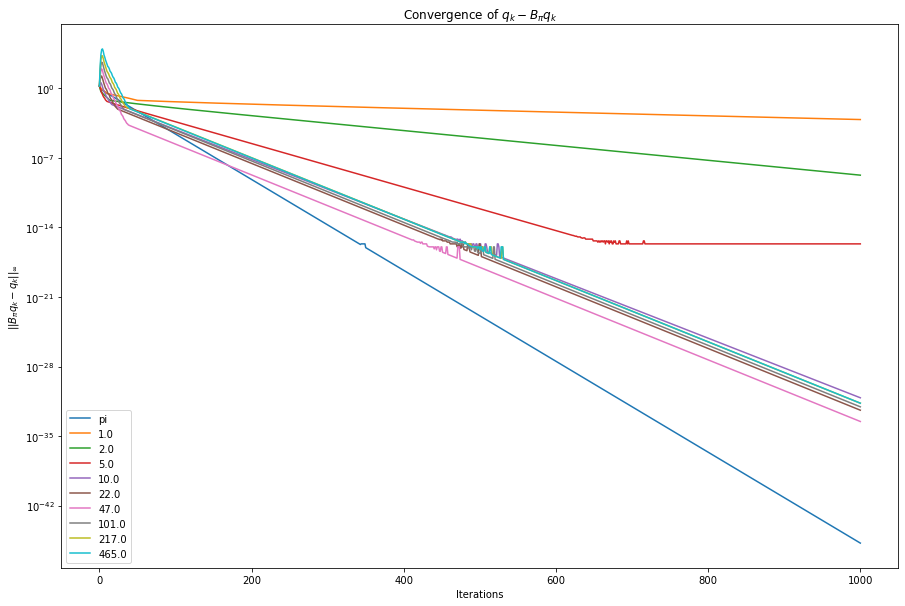

In [40]:
fig = plt.figure(figsize=(15, 10))

for key, value in dic_Bpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $q_k - B_{\pi}q_k$')
plt.xlabel('Iterations')
plt.ylabel('$||B_{\pi}q_{k}-q_{k}||_{\infty}$')
plt.legend()
plt.show()

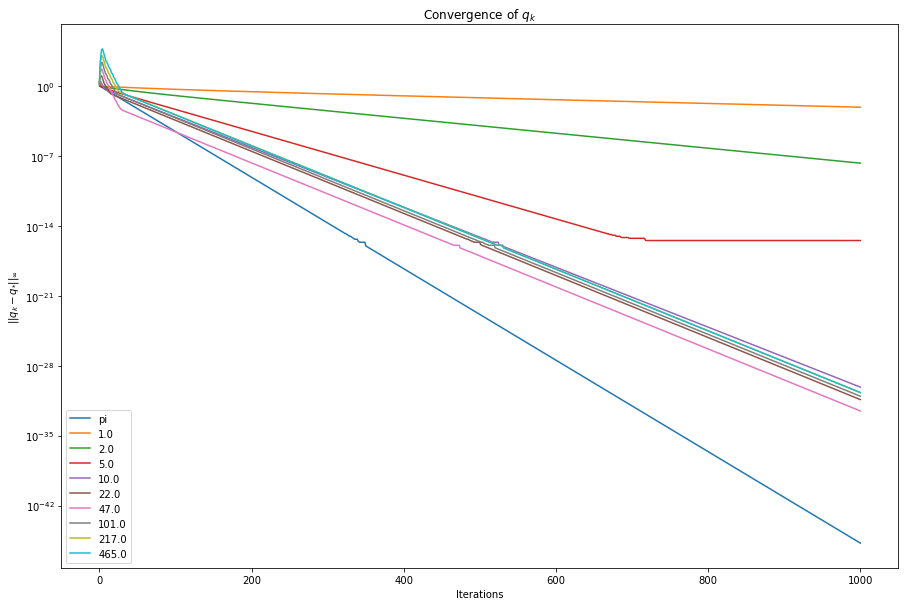

In [41]:
fig = plt.figure(figsize=(15, 10))


for key, value in dic_vpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $q_{k}$')
plt.xlabel('Iterations')
plt.ylabel('$||q_{k}-q_{*}||_{\infty}$')
plt.legend()
plt.show()


### Variante de (Ada-FP) définie composante par composante

In [26]:
v_0 = np.random.random(maze.shape)
policy = stationnary_policy(v_0)

In [27]:
v_star = copy.deepcopy(v_0)

for _ in range(10000):
    v_star = B_pi(v_star, policy)


In [29]:
v = copy.deepcopy(v_0)

diff_Bpi = [np.max(np.abs(B_pi(v, policy)-v))]
diff_vpi = [np.max(np.abs(v-v_star))]

dic_Bpi = {}
dic_vpi = {}

for _ in range(100):
    v = B_pi(v, policy)
    diff_Bpi.append(np.max(np.abs(B_pi(v, policy)-v)))
    diff_vpi.append(np.max(np.abs(v-v_star)))

dic_Bpi['pi'] = copy.deepcopy(diff_Bpi)
dic_vpi['pi'] = copy.deepcopy(diff_vpi)

eta_tab = 10**np.linspace(0.01, 3, 10)[:-1]

for eta in eta_tab:
    v = copy.deepcopy(v_0)

    ponderation = np.zeros_like(v)
    diff_Bpi = [np.max(np.abs(B_pi(v, policy)-v))]
    diff_vpi = [np.max(np.abs(v_star-v))]

    for _ in range(100):
        new_v = np.zeros_like(v)
        temp = eta * (B_pi(v, policy)-v)
        for i in range(v.shape[0]):
            for j in range(v.shape[1]):
                ponderation[i][j] += (B_pi(v, policy)[i][j]-v[i][j])**2
                new_v[i][j] = v[i][j] + temp[i][j]/np.sqrt(ponderation[i][j])


        v = copy.deepcopy(new_v)

        diff_Bpi.append(np.max(np.abs(B_pi(v, policy)-v)))
        diff_vpi.append(np.max(np.abs(v-v_star)))

    dic_Bpi[eta] = copy.deepcopy(diff_Bpi)
    dic_vpi[eta] = copy.deepcopy(diff_vpi)

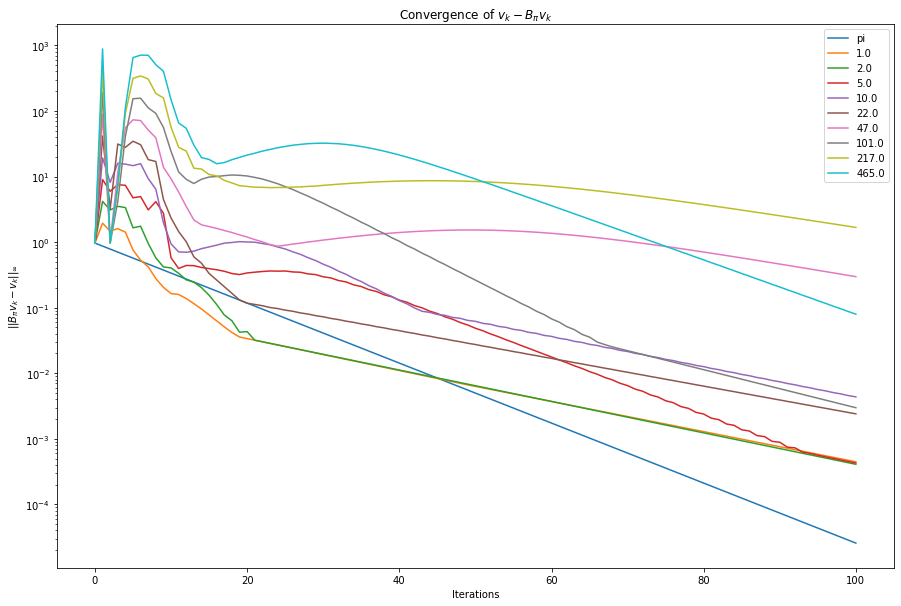

In [30]:
fig = plt.figure(figsize=(15, 10))

for key, value in dic_Bpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $v_k - B_{\pi}v_k$')
plt.xlabel('Iterations')
plt.ylabel('$||B_{\pi}v_{k}-v_{k}||_{\infty}$')
plt.legend()
plt.show()

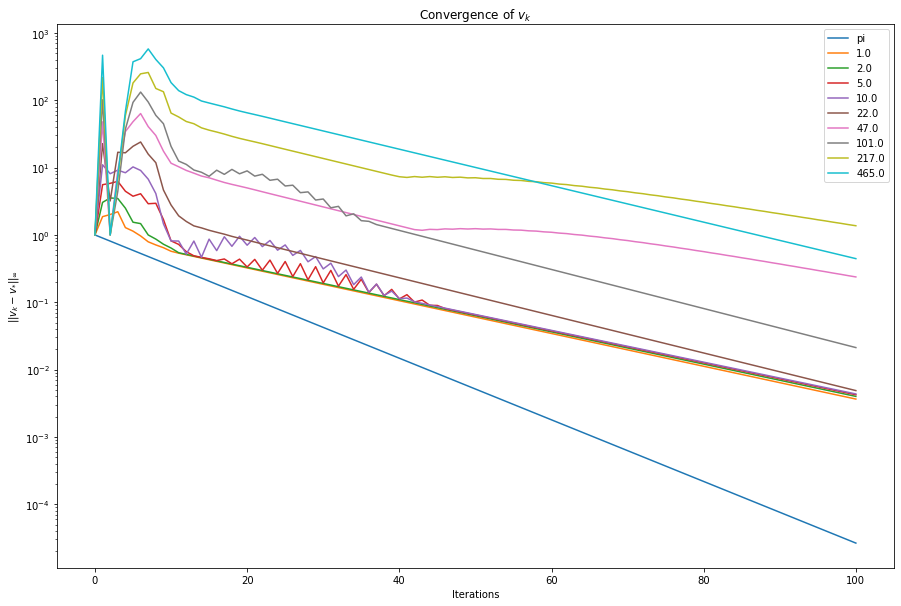

In [31]:
fig = plt.figure(figsize=(15, 10))


for key, value in dic_vpi.items():
    if key == 'pi':
        plt.plot(value, label=key)
    else:
        plt.plot(value, label=np.round(key, 0))

plt.yscale('log')
plt.title('Convergence of $v_{k}$')
plt.xlabel('Iterations')
plt.ylabel('$||v_{k}-v_{*}||_{\infty}$')
plt.legend()
plt.show()
